In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.ndimage import gaussian_filter
from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp

from tqdm import trange
import pystan
from xdgmm import XDGMM

In [2]:
phi1_lim = [-100, 20] * u.deg

In [3]:
g = GaiaData('../data/gd1-master.fits')
g = g[g.gi_cmd_mask & (g.phi1 > phi1_lim[0]) & (g.phi1 < phi1_lim[1])]
c = g.get_skycoord(distance=False)
c_gd1 = c.transform_to(gc.GD1)
phi1 = c_gd1.phi1.wrap_at(180*u.deg).degree

In [4]:
X_pm = np.stack((c_gd1.pm_phi1_cosphi2.value,
                 c_gd1.pm_phi2.value)).T

In [5]:
Cov = g.get_cov()[:, 3:5, 3:5]
Cov_pm = gc.transform_pm_cov(c, Cov, gc.GD1)

In [6]:
orbit_track = Table.read('../output/orbit_track.ecsv')
_mask = (orbit_track['phi1'] > g.phi1.value.min())& (orbit_track['phi1'] < g.phi1.value.max())
orbit_track = orbit_track[_mask]

_sort = orbit_track['phi1'].argsort()
interp_pm1 = InterpolatedUnivariateSpline(orbit_track['phi1'][_sort], 
                                          orbit_track['pm_phi1_cosphi2'][_sort], k=3)
interp_pm2 = InterpolatedUnivariateSpline(orbit_track['phi1'][_sort], 
                                          orbit_track['pm_phi2'][_sort], k=3)

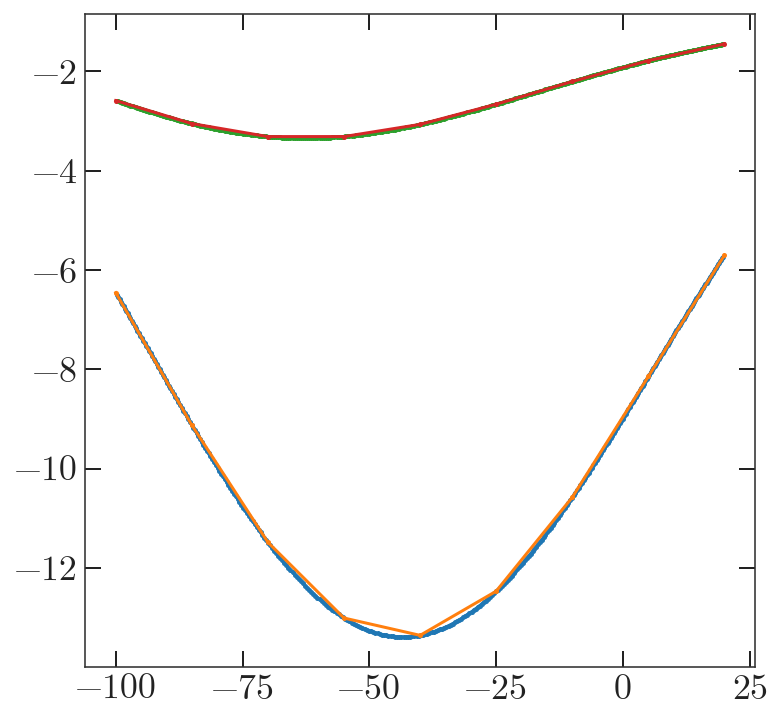

In [7]:
pm_nodes = np.arange(phi1_lim[0].value, phi1_lim[1].value+1e-3, 15.)

plt.plot(orbit_track['phi1'], orbit_track['pm_phi1_cosphi2'])
_interp_pm1 = InterpolatedUnivariateSpline(pm_nodes, interp_pm1(pm_nodes), 
                                           k=3, bbox=[-100, 20])
plt.plot(pm_nodes, _interp_pm1(pm_nodes))

plt.plot(orbit_track['phi1'], orbit_track['pm_phi2'])
_interp_pm2 = InterpolatedUnivariateSpline(pm_nodes, interp_pm2(pm_nodes), 
                                           k=3, bbox=[-100, 20])
plt.plot(pm_nodes, _interp_pm2(pm_nodes))

In [8]:
interp_pm1(0.), interp_pm2(0.)

(array(-8.98049464), array(-1.91592785))

In [9]:
phi12_poly = np.load('../output/phi12_poly.npy')[:64]
phi12_poly[:, 1] += 1.5
phi12_poly = np.concatenate((np.array([[-90, -3.7],
                                       [-95, -4.4],
                                       [-100., -5]]), phi12_poly))

_f = interp1d(phi12_poly[:, 0], phi12_poly[:, 1], kind='cubic')
_x = np.linspace(-100, 20, 256)
track = _f(_x)
gd1_track = np.stack((_x, track)).T

# Now make a selection for the stream:
_top = gd1_track.copy()
_top[:, 1] += 2.5
_btm = gd1_track.copy()
_btm[:, 1] -= 2.5

gd1_poly = np.vstack((_top, _btm[1:][::-1]))
gd1_phi_path = mpl.path.Path(gd1_poly)

# Now make a selection off of the stream:
_top = gd1_track.copy()
_top[:, 1] += 5
_btm = gd1_track.copy()
_btm[:, 1] += 5-2.5
ctl_poly1 = np.vstack((_top, _btm[1:][::-1]))

_top = gd1_track.copy()
_top[:, 1] -= 5-2.5
_btm = gd1_track.copy()
_btm[:, 1] -= 5
ctl_poly2 = np.vstack((_top, _btm[1:][::-1]))

ctl_phi_path = [mpl.path.Path(ctl_poly1),
                mpl.path.Path(ctl_poly2)]

X = np.stack((g.phi1.value, g.phi2.value)).T
sky_gd1_mask = gd1_phi_path.contains_points(X)
sky_ctl_mask = ctl_phi_path[0].contains_points(X) | ctl_phi_path[1].contains_points(X)

(-10, 5)

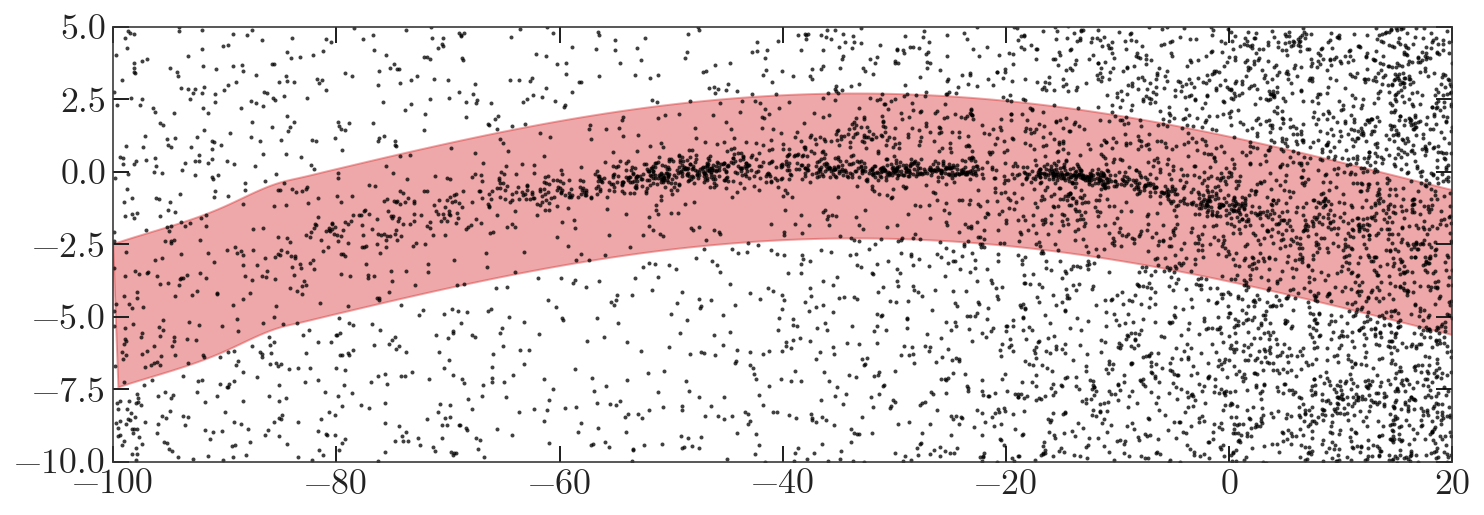

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(g.phi1[g.gi_cmd_mask & g.pm_mask], 
        g.phi2[g.gi_cmd_mask & g.pm_mask], 
        ls='none', marker='o', color='k', 
        alpha=0.75, ms=2)

ax.add_patch(mpl.patches.Polygon(gd1_phi_path.vertices, color='tab:red', alpha=0.4))
# ax.add_patch(mpl.patches.Polygon(ctl_phi_path[0].vertices, color='tab:blue', alpha=0.4))
# ax.add_patch(mpl.patches.Polygon(ctl_phi_path[1].vertices, color='tab:blue', alpha=0.4))

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

In [ ]:
# for initializing the amplitude spline
log_a_inits = []
for i in range(len(pm_nodes)-1):
    l, r = pm_nodes[i], pm_nodes[i+1]
    phi1_mask = (g.phi1.value >= l) & (g.phi1.value < r)
    
    mask1 = phi1_mask & sky_gd1_mask & g.pm_mask
    mask2 = phi1_mask & sky_gd1_mask
    log_a_inits.append(np.log(mask1.sum() / mask2.sum()))

In [ ]:
phi1_bins = np.arange(phi1_lim[0].value, phi1_lim[1].value+1e-3, 5)
pm_bins = np.arange(-20, 20+1e-3, 0.5)

gmms = []
for i in trange(len(phi1_bins)-1):
    l, r = phi1_bins[i], phi1_bins[i+1]
    phi1_mask = (g.phi1.value >= l) & (g.phi1.value < r)
    control_mask = phi1_mask & np.logical_not(sky_gd1_mask)
    
    X_pm_ctl = X_pm[control_mask]
    C_pm_ctl = Cov_pm[control_mask]
    
    # MAGIC NUMBER: 4-5 from experimenting with the BIC
    gmm = XDGMM(n_components=5, method='Bovy')
    _ = gmm.fit(X_pm_ctl, C_pm_ctl)
    gmms.append(gmm)
    
    # ---

    fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                             sharex=True, sharey=True)

    ax = axes[0]
    H, xe, ye = np.histogram2d(X_pm_ctl[:, 0], X_pm_ctl[:, 1],
                               bins=pm_bins)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm())

    ax = axes[1]
    _samples = gmm.sample(size=len(X_pm_ctl))
    H, xe, ye = np.histogram2d(_samples[:, 0], _samples[:, 1],
                               bins=pm_bins)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm())
    
    axes[0].set_xlabel(r'$\mu_1$ [{:latex_inline}]'.format(u.mas/u.yr))
    axes[0].set_ylabel(r'$\mu_2$ [{:latex_inline}]'.format(u.mas/u.yr))
    axes[1].set_xlabel(r'$\mu_1$ [{:latex_inline}]'.format(u.mas/u.yr))
    axes[0].set_title(r'data (${:.1f} < \phi_1 < {:.1f}$)'.format(l, r))
    axes[1].set_title(r'XD model')
    fig.tight_layout()

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
X_pm_gd1 = X_pm[sky_gd1_mask]
C_pm_gd1 = Cov_pm[sky_gd1_mask]
phi1_gd1 = phi1[sky_gd1_mask]

In [ ]:
sm = pystan.StanModel('../stan/pm_model.stan')

In [ ]:
data = dict()
data['D'] = 2

data['M'] = len(phi1_bins) - 1
data['phi1_bins'] = phi1_bins
data['phi1'] = phi1_gd1

data['K_bg'] = gmm.n_components
data['mu_bg'] = np.stack([gmm.mu for gmm in gmms])
data['cov_bg'] = np.stack([gmm.V for gmm in gmms])
data['a_bg'] = np.stack([gmm.weights for gmm in gmms])

data['N'] = len(X_pm_gd1)
data['pm'] = X_pm_gd1
data['cov_pm'] = C_pm_gd1

data['n_pm_nodes'] = len(pm_nodes)
data['pm_nodes'] = pm_nodes

data['pm1_nodes_init'] = interp_pm1(pm_nodes)
data['pm2_nodes_init'] = interp_pm2(pm_nodes)

In [ ]:
init = dict()
# init['s_gd1'] = 0.05
# init['alpha'] = 0.05

init['pm1_nodes'] = data['pm1_nodes_init']
init['pm2_nodes'] = data['pm2_nodes_init']

init['log_s1_nodes'] = np.full(len(pm_nodes), np.log(0.05))
init['log_s2_nodes'] = np.full(len(pm_nodes), np.log(0.05))

init['log_a_nodes'] = log_a_inits + [np.log(0.001)]

In [17]:
fit = sm.optimizing(data=data, init=init, iter=256)

/Users/adrian/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
with open('pm_model_fit.pkl', 'wb') as f:
    pickle.dump(fit, f)

In [18]:
fit

OrderedDict([('pm1_nodes',
              array([ -6.37495388,  -9.28061005, -11.537909  , -13.11568899,
                     -13.38963025, -12.24503877, -10.10408568,  -7.87058351,
                      -5.68255542])),
             ('pm2_nodes',
              array([-2.64183186, -3.28472506, -3.59153892, -3.55808227, -3.21711752,
                     -2.86865872, -2.41299688, -1.89148372, -1.494618  ])),
             ('log_s1_nodes',
              array([-2.23000898, -2.49970446, -1.40620625, -2.53364366, -1.08165206,
                     -1.92226542, -0.12087143, -1.43191834, -2.40315176])),
             ('log_s2_nodes',
              array([-2.28992221, -1.87735706, -1.739505  , -1.3516023 , -1.93564112,
                     -2.2783288 , -2.38471506, -1.21274191, -2.2888433 ])),
             ('log_a_nodes',
              array([-14.92678377,  -6.77458161,  -5.08416417,  -3.4756038 ,
                      -3.26996375,  -3.31232461,  -3.46402128,  -4.63140362,
                      -7.

In [20]:
post_prob = np.exp(fit['log_p_stream'] - np.logaddexp(fit['log_p_stream'], fit['log_p_bg']))

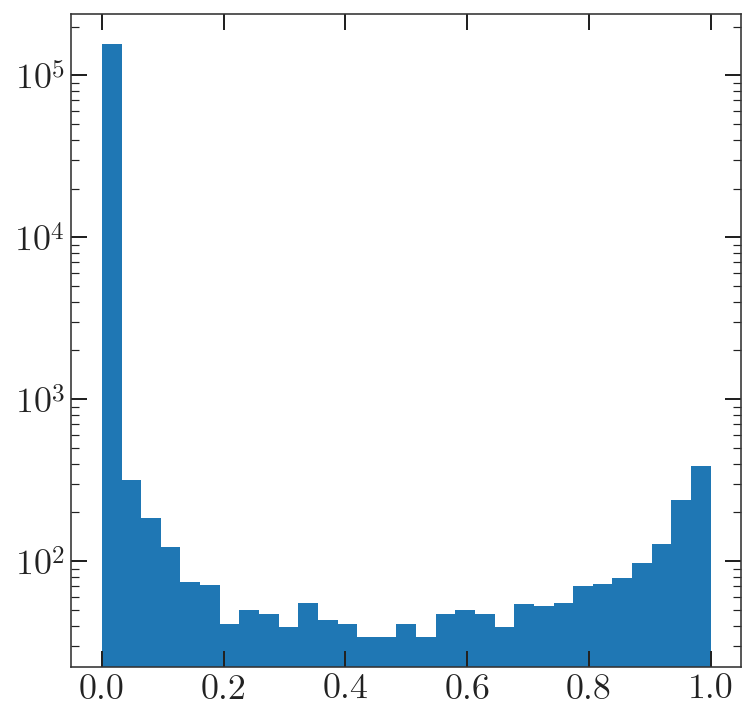

In [21]:
plt.hist(post_prob, bins=np.linspace(0, 1, 32));
plt.yscale('log')

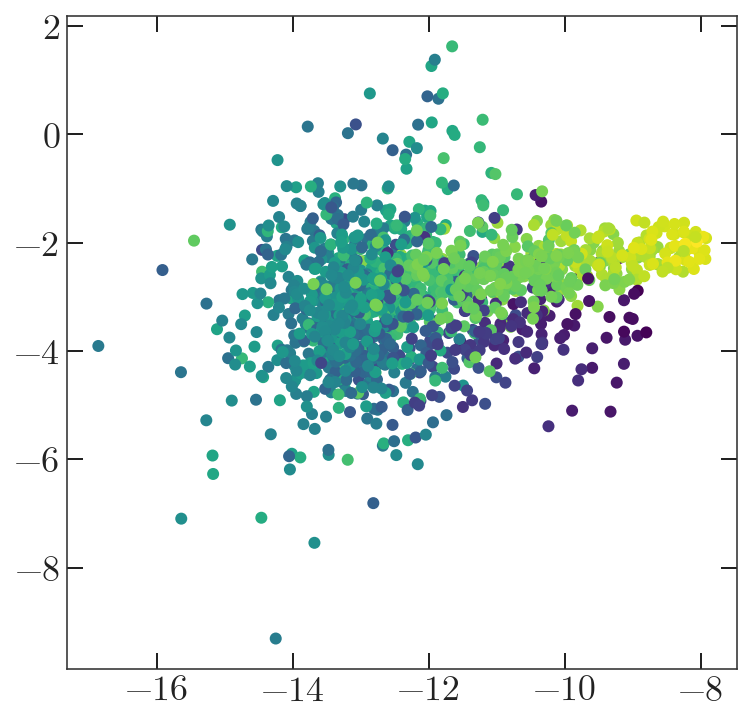

In [22]:
prob_cut = 0.5
plt.scatter(X_pm_gd1[(post_prob > prob_cut), 0],
            X_pm_gd1[(post_prob > prob_cut), 1],
            c=phi1_gd1[(post_prob > prob_cut)],
            marker='o')

(-10, 5)

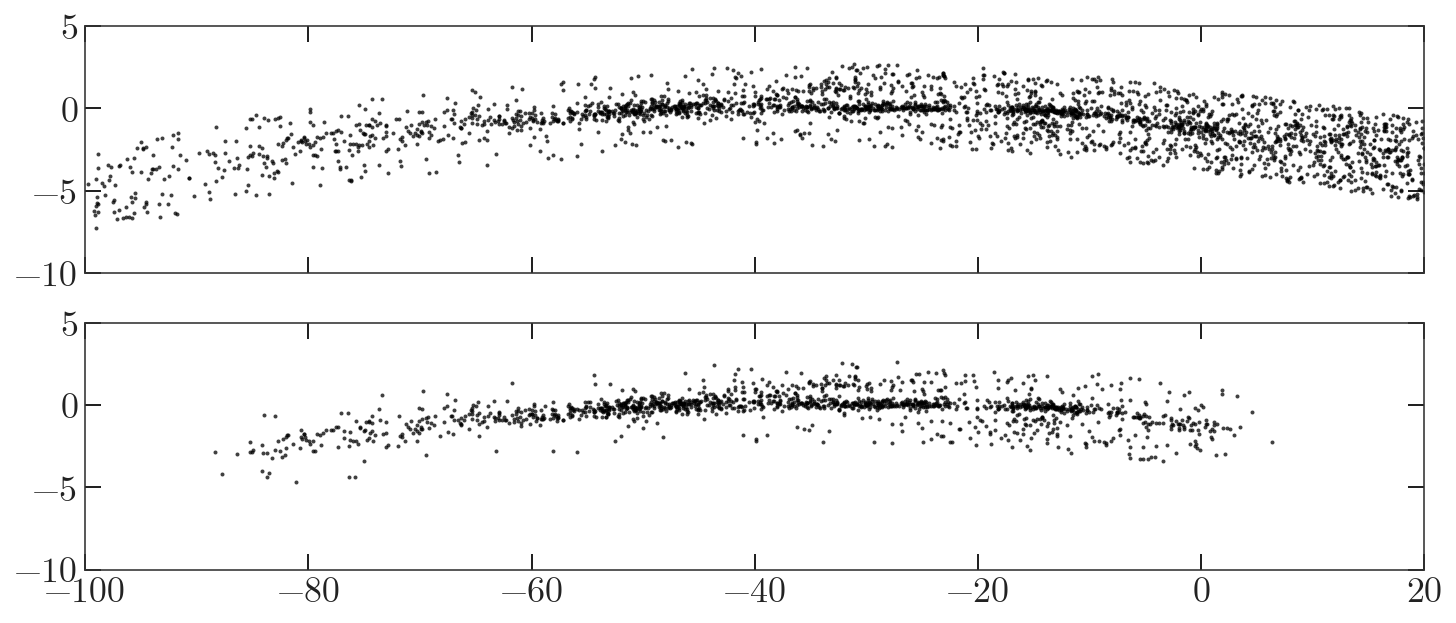

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(g.phi1[sky_gd1_mask & g.pm_mask],
        g.phi2[sky_gd1_mask & g.pm_mask],
        ls='none', marker='o', color='k', 
        alpha=0.75, ms=2)

ax = axes[1]
ax.plot(g.phi1[sky_gd1_mask][(post_prob > 0.5)], 
        g.phi2[sky_gd1_mask][(post_prob > 0.5)], 
        ls='none', marker='o', color='k', 
        alpha=0.75, ms=2)

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)

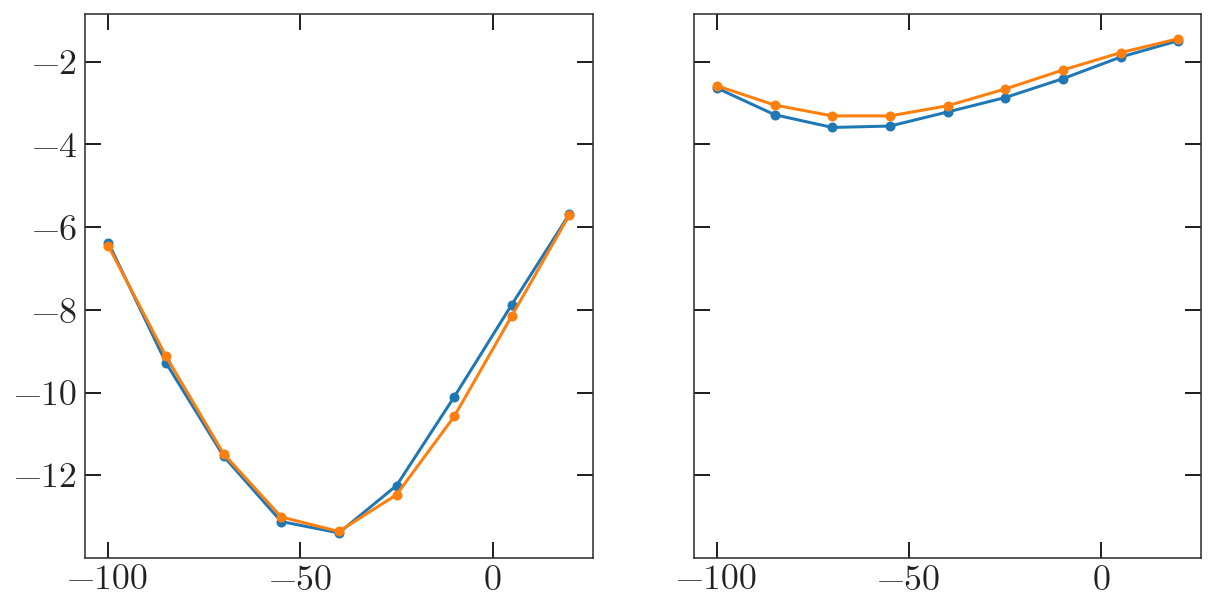

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot(data['pm_nodes'], fit['pm1_nodes'], marker='o')
axes[0].plot(data['pm_nodes'], data['pm1_nodes_init'], marker='o')

axes[1].plot(data['pm_nodes'], fit['pm2_nodes'], marker='o')
axes[1].plot(data['pm_nodes'], data['pm2_nodes_init'], marker='o')

# axes[1].set_ylim(-1, 1)

# Now sample:

In [27]:
sample_init = dict()
for k in init:
    sample_init[k] = fit[k]

In [ ]:
%%time
fit_s = sm.sampling(data=data, 
                    init=[sample_init], chains=1,
                    iter=64, n_jobs=1,
                    algorithm='NUTS')

In [106]:
post_prob = np.sum(np.exp(fit['log_p_stream'] - np.logaddexp(fit['log_p_stream'], fit['log_p_bg'])),
                   axis=0) / fit['log_p_stream'].shape[0]

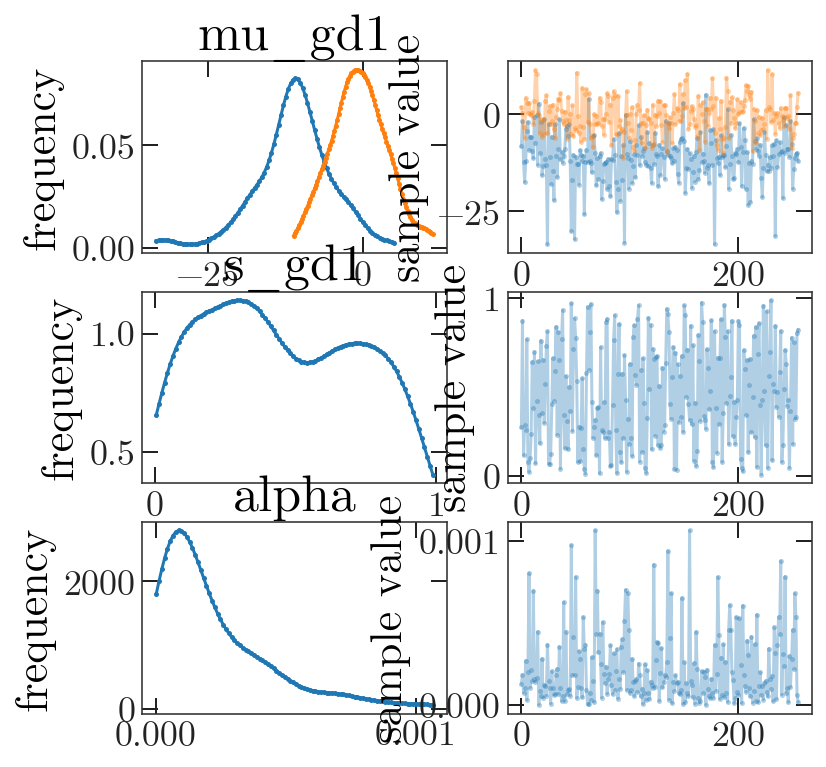

In [107]:
_ = fit.plot(pars=['mu_gd1', 
                   's_gd1',
                   'alpha'])

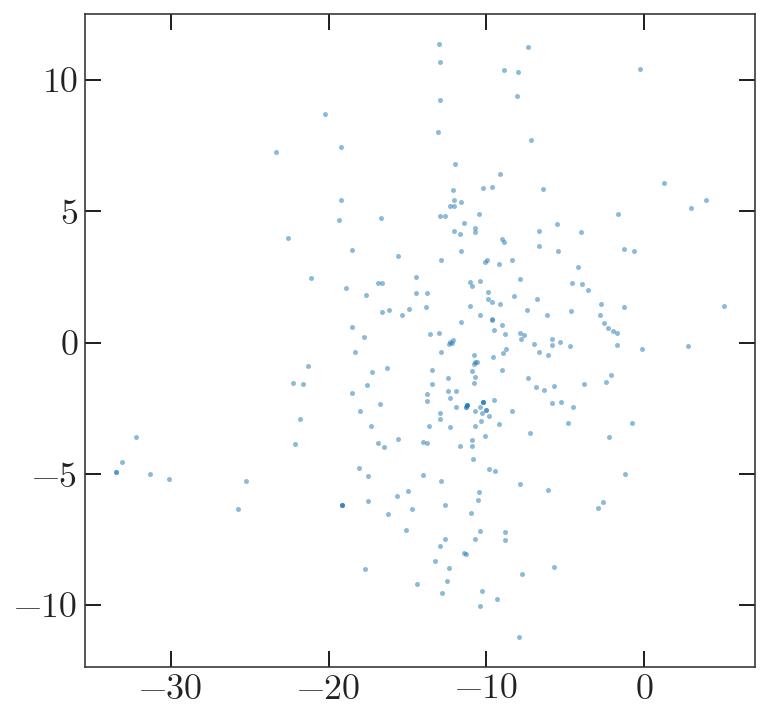

In [108]:
plt.plot(fit['mu_gd1'][:, 0],
         fit['mu_gd1'][:, 1],
         marker='o', ls='none', 
         ms=2.5, alpha=0.5)

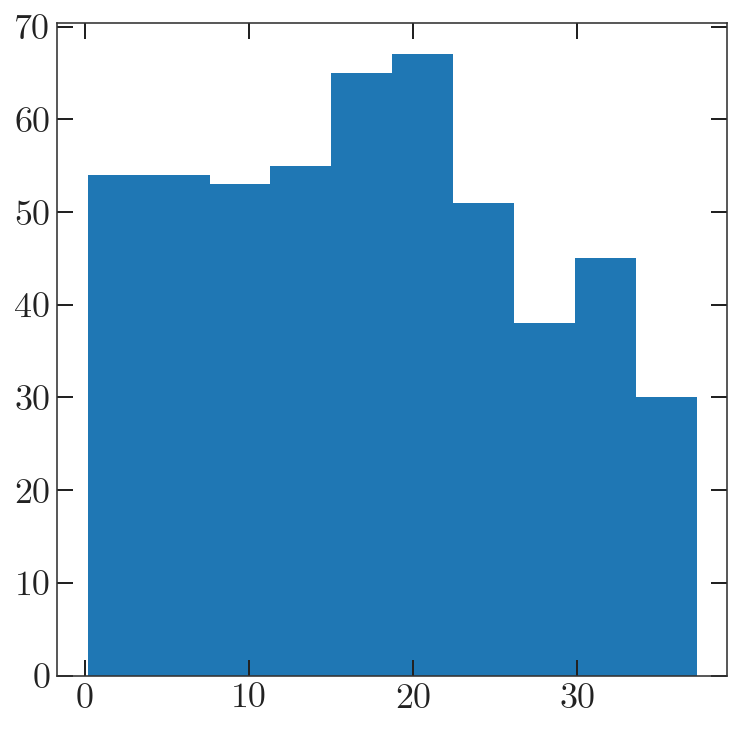

In [72]:
plt.hist((fit['s_gd1']*u.mas/u.yr * 8*u.kpc).to(u.km/u.s, u.dimensionless_angles()).value);

In [58]:
len(g[stream_mask & g.gi_cmd_mask & g.pm_mask]) / len(g[stream_mask & g.gi_cmd_mask])

0.042738074126618196